In [1]:
import $file.^.Magic

import $file.$

In [2]:
Magic.!("pip", "install", "torch==2.4.*")


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [3]:
import $ivy.`dev.scalapy::scalapy-core:0.5.3`

import $ivy.$

In [4]:
case class GPTConfig(
  vocabularySize: Int,
  contextLength: Int,
  embeddingDimension: Int,
  attentionHeadsCount: Int,
  layersCount: Int,
  dropoutRate: Double,
  queryKeyValueBias: Boolean
)

val gptConfig = GPTConfig(
  vocabularySize = 50_257,
  contextLength = 1024,
  embeddingDimension = 768,
  attentionHeadsCount = 12,
  layersCount = 12,
  dropoutRate = 0.1,
  queryKeyValueBias = false
)

defined class GPTConfig
gptConfig: GPTConfig = GPTConfig(
  vocabularySize = 50257,
  contextLength = 1024,
  embeddingDimension = 768,
  attentionHeadsCount = 12,
  layersCount = 12,
  dropoutRate = 0.1,
  queryKeyValueBias = false
)

In [5]:
import me.shadaj.scalapy.py
import py.SeqConverters

val torch = py.module("torch")

// Workaround to define a class that inherits from a Python class
py.exec {
  s"""import torch.nn as nn
     |
     |class DummyTransformerBlock(nn.Module):
     |  def __init__(self, init):
     |    super().__init__()
     |    init(self)
     |""".stripMargin
}
type TorchTensor = py.Dynamic
def DummyTransformerBlock(
  config: GPTConfig
): py.Dynamic = {
  val init = (self: py.Dynamic) => {
    val forward = (inputs: TorchTensor) => inputs
    self.forward = forward
  }
  py.Dynamic.global.DummyTransformerBlock(init)
}

import me.shadaj.scalapy.py
import py.SeqConverters
torch: py.Module = <module 'torch' from '/usr/local/lib/python3.12/site-packages/torch/__init__.py'>
defined type TorchTensor
defined function DummyTransformerBlock

In [6]:
// Workaround to define a class that inherits from a Python class
py.exec {
  s"""import torch.nn as nn
     |
     |class DummyNormalizationLayer(nn.Module):
     |  def __init__(self, init):
     |    super().__init__()
     |    init(self)
     |""".stripMargin
}
def DummyNormalizationLayer(
  normalizedShape: Int,
  eps: Double = 1e-5
): py.Dynamic = {
  val init = (self: py.Dynamic) => {
    val forward = (inputs: TorchTensor) => inputs
    self.forward = forward
  }
  py.Dynamic.global.DummyNormalizationLayer(init)
}

defined function DummyNormalizationLayer

In [7]:
import scala.util.chaining._
import py.PyQuote

// Workaround to define a class that inherits from a Python class
py.exec {
  s"""import torch.nn as nn
     |
     |class DummyGPTModel(nn.Module):
     |  def __init__(self, init):
     |    super().__init__()
     |    init(self)
     |""".stripMargin
}
def DummyGPTModel(
  config: GPTConfig
): py.Dynamic = {
  val tokenEmbeddingLayer = torch.nn.Embedding(config.vocabularySize, config.embeddingDimension)
  val positionEmbeddingLayer = torch.nn.Embedding(config.contextLength, config.embeddingDimension)
  val dropoutEmbeddingLayer = torch.nn.Dropout(config.dropoutRate)
  val transformerBlocks = Seq.fill(config.layersCount)(DummyTransformerBlock(config))
  val transformerBlocksLayer = py"nn.Sequential(*${transformerBlocks.toPythonProxy})"
  val finalNormalizationLayer = DummyNormalizationLayer(config.embeddingDimension)
  val outputLayer = torch.nn.Linear(config.embeddingDimension, config.vocabularySize, bias = false)
  val init = (self: py.Dynamic) => {
    val forward = (batchedInputs: TorchTensor) => {
      val (batchSize, sequenceLength) = batchedInputs.shape.as[(Int, Int)]
      val tokenEmbeddings = tokenEmbeddingLayer(batchedInputs)
      val positionEmbeddings = positionEmbeddingLayer(torch.arange(sequenceLength, device = batchedInputs.device))
      py"$tokenEmbeddings + $positionEmbeddings"
        .pipe(dropoutEmbeddingLayer(_))
        .pipe(transformerBlocksLayer(_))
        .pipe(finalNormalizationLayer(_))
        .pipe(outputLayer(_))
    }
    self.forward = forward
  }
  py.Dynamic.global.DummyGPTModel(init)
}

import scala.util.chaining._
import py.PyQuote
defined function DummyGPTModel

In [8]:
Magic.!("pip", "install", "tiktoken==0.7.*")


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [9]:
val tiktoken = py.module("tiktoken")

val tokenizer = tiktoken.get_encoding("gpt2")
val dummyBatch = torch.stack(
  py.Dynamic.global.tuple(
    Seq("Every effort moves you",  "Every day holds a")
      .map(tokenizer.encode(_))
      .map(torch.tensor(_))
      .toPythonProxy
  ),
  dim = 0
)
println(dummyBatch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


tiktoken: py.Module = <module 'tiktoken' from '/usr/local/lib/python3.12/site-packages/tiktoken/__init__.py'>
tokenizer: py.Dynamic = <Encoding 'gpt2'>
dummyBatch: py.Dynamic = tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

In [10]:
torch.manual_seed(123)
val dummyGPTModel = DummyGPTModel(gptConfig)
val output = dummyGPTModel(dummyBatch)
println(s"Output shape: ${output.shape}")
println(output)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


res10_0: py.Dynamic = <torch._C.Generator object at 0xffff88a6a7b0>
dummyGPTModel: py.Dynamic = DummyGPTModel()
output: py.Dynamic = tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)

In [11]:
// Workaround to define a class that inherits from a Python class
py.exec {
  s"""import torch.nn as nn
     |
     |class NormalizationLayer(nn.Module):
     |  def __init__(self, init):
     |    super().__init__()
     |    init(self)
     |""".stripMargin
}
def NormalizationLayer(
  embeddingDimension: Int
): py.Dynamic = {
  val epsilon = 1e-5
  val scale = torch.nn.Parameter(torch.ones(embeddingDimension))
  val shift = torch.nn.Parameter(torch.zeros(embeddingDimension))
  val init = (self: py.Dynamic) => {
    val forward = (inputs: TorchTensor) => {
      val mean = inputs.mean(dim = -1, keepdim = true)
      val variance = inputs.`var`(dim = -1, keepdim = true, unbiased = false)
      val normalizedInputs = py"($inputs - $mean) / torch.sqrt($variance + $epsilon)"
      py"$scale * $normalizedInputs + $shift"
    }
    self.forward = forward
  }
  py.Dynamic.global.NormalizationLayer(init)
}

defined function NormalizationLayer

In [12]:
// Workaround to define a class that inherits from a Python class
// Because it mostly uses Python operators, it's implemented fully in Python
py.exec {
  s"""import torch
     |import torch.nn as nn
     |
     |class GELU(nn.Module):
     |  def __init__(self):
     |    super().__init__()
     |
     |  def forward(self, inputs):
     |    return 0.5 * inputs * (
     |      1 + torch.tanh(
     |        torch.sqrt(torch.tensor(2.0 / torch.pi)) * (inputs + 0.044715 * torch.pow(inputs, 3))
     |      )
     |    )
     |""".stripMargin
}
def GELU() = py.Dynamic.global.GELU()

defined function GELU

In [13]:
Magic.!("pip", "install", "matplotlib==3.9.*")


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [14]:
val display = py.module("IPython.display")
almond.scalapy.initDisplay
// Workaround becasue neither `plot.show()` nor `display.display(plot.gcf())` work
val io = py.module("io")
type Plot = py.Dynamic
def showPlot(plot: Plot): Plot = {
  val buffer = io.BytesIO()
  plot.savefig(buffer, format = "png")
  buffer.seek(0)
  display.Image(buffer.read())
}

display: py.Module = <module 'IPython.display' from '/usr/local/lib/python3.12/site-packages/IPython/display.py'>
io: py.Module = <module 'io' (frozen)>
defined type Plot
defined function showPlot

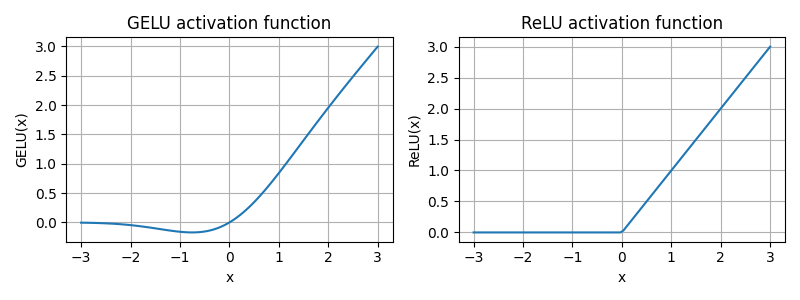

plot: py.Module = <module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [15]:
val plot = py.module("matplotlib.pyplot")

try {
  val input = torch.linspace(-3, 3, 100)
  plot.figure(figsize = (8, 3))

  def subplot(name: String, index: Int, output: TorchTensor) = {
    plot.subplot(1, 2, index)
    plot.plot(input, output)
    plot.title(s"$name activation function")
    plot.xlabel("x")
    plot.ylabel(s"$name(x)")
    plot.grid(true)
  }

  val gelu = GELU()
  val geluOutput = gelu(input)
  subplot("GELU", 1, geluOutput)

  val relu = torch.nn.ReLU()
  val reluOutput = relu(input)
  subplot("ReLU", 2, reluOutput)

  plot.tight_layout()
  showPlot(plot)
} catch {
  case e: py.PythonException =>
    println("(!) If the exception below says 'Numpy is not available', restart the Jupyter kernel. It's an issue with Matplotlib in Jupyter.\n")
    throw e
}

In [16]:
// Workaround to define a class that inherits from a Python class
py.exec {
  s"""import torch.nn as nn
     |
     |class FeedForward(nn.Module):
     |  def __init__(self, init):
     |    super().__init__()
     |    init(self)
     |""".stripMargin
}
def FeedForward(
  embeddingDimension: Int
): py.Dynamic = {
  val layers = torch.nn.Sequential(
    torch.nn.Linear(embeddingDimension, 4 * embeddingDimension),
    GELU(),
    torch.nn.Linear(4 * embeddingDimension, embeddingDimension)
  )
  val init = (self: py.Dynamic) => {
    val forward = (inputs: TorchTensor) => layers(inputs)
    self.forward = forward
  }
  py.Dynamic.global.FeedForward(init)
}

defined function FeedForward

In [17]:
// Workaround to define a class that inherits from a Python class
py.exec {
  s"""import torch.nn as nn
     |
     |class MultiHeadAttention(nn.Module):
     |  def __init__(self, init):
     |    super().__init__()
     |    init(self)
     |""".stripMargin
}
type Mask = py.Dynamic
def MultiHeadAttention(
  inputDimension: Int,
  outputDimension: Int,
  dropoutProbability: Double,
  contextLength: Int,
  headsCount: Int,
  queryKeyValueBias: Boolean
): py.Dynamic = {
  assert(outputDimension % headsCount == 0, "Output dimension must be a multiple of heads count")
  val headDimension = outputDimension / headsCount
    
  val weightsQuery = torch.nn.Linear(inputDimension, outputDimension, bias = queryKeyValueBias)
  val weightsKey = torch.nn.Linear(inputDimension, outputDimension, bias = queryKeyValueBias)
  val weightsValue = torch.nn.Linear(inputDimension, outputDimension, bias = queryKeyValueBias)
  val outputProjection = torch.nn.Linear(outputDimension, outputDimension)
  val dropout = torch.nn.Dropout(dropoutProbability)
    
  val init = (self: py.Dynamic) => {
    self.register_buffer("mask", torch.triu(torch.ones(contextLength, contextLength), diagonal = 1))
    val mask = self.mask
      
    val forward = (batchedInputs: TorchTensor) => {
      val (batchesCount, tokensCount, tokenDimension) = batchedInputs.shape.as[(Int, Int, Int)]
      val queries = weightsQuery(batchedInputs)
        .view(batchesCount, tokensCount, headsCount, headDimension)
        .transpose(1, 2)
      val keys = weightsKey(batchedInputs)
        .view(batchesCount, tokensCount, headsCount, headDimension)
        .transpose(1, 2)
      val values = weightsValue(batchedInputs)
        .view(batchesCount, tokensCount, headsCount, headDimension)
        .transpose(1, 2)
      val attentionScores = py"$queries @ $keys.transpose(2, 3)"
      attentionScores.masked_fill_(py"$mask.bool()[:$tokensCount, :$tokensCount]", -torch.inf)
      val attentionWeights = dropout(torch.softmax(py"$attentionScores / $headDimension**0.5", dim = -1))
      outputProjection(
        py"$attentionWeights @ $values"
          .transpose(1, 2)
          .contiguous()
          .view(batchesCount, tokensCount, outputDimension)
      )
    }
    self.forward = forward
  }
  py.Dynamic.global.MultiHeadAttention(init)
}

defined type Mask
defined function MultiHeadAttention

In [18]:
import scala.util.chaining._

py.exec {
  s"""import torch.nn as nn
     |
     |class TransformerBlock(nn.Module):
     |  def __init__(self, init):
     |    super().__init__()
     |    init(self)
     |""".stripMargin
}
def TransformerBlock(
  config: GPTConfig
): py.Dynamic = {
  val multiHeadAttention = MultiHeadAttention(
    inputDimension = config.embeddingDimension,
    outputDimension = config.embeddingDimension,
    dropoutProbability = config.dropoutRate,
    contextLength = config.contextLength,
    headsCount = config.attentionHeadsCount,
    queryKeyValueBias = config.queryKeyValueBias
  )
  val feedForward = FeedForward(config.embeddingDimension)
  val normalization1 = NormalizationLayer(config.embeddingDimension)
  val normalization2 = NormalizationLayer(config.embeddingDimension)
  val dropoutShortcut = torch.nn.Dropout(config.dropoutRate)
  val init = (self: py.Dynamic) => {
    val forward = (inputs: TorchTensor) => {
      val shortcut = inputs
      val newShortcut = inputs
        .pipe(normalization1(_))
        .pipe(multiHeadAttention(_))
        .pipe(dropoutShortcut(_))
        .pipe(o => py"$o + $shortcut")
      newShortcut
        .pipe(normalization2(_))
        .pipe(feedForward(_))
        .pipe(dropoutShortcut(_))
        .pipe(o => py"$o + $newShortcut")
    }
    self.forward = forward
  }
  py.Dynamic.global.TransformerBlock(init)
}

import scala.util.chaining._
defined function TransformerBlock

In [19]:
torch.manual_seed(123)
val exampleInput = torch.rand(2, 4, 768)
val exampleTransformerBlock = TransformerBlock(gptConfig)
val exampleOutput = exampleTransformerBlock(exampleInput)

println(s"Input shape: ${exampleInput.shape}")
println(s"Output shape: ${exampleOutput.shape}")

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


res19_0: py.Dynamic = <torch._C.Generator object at 0xffff88a6a7b0>
exampleInput: py.Dynamic = tensor([[[0.2961, 0.5166, 0.2517,  ..., 0.9541, 0.8567, 0.4604],
         [0.2238, 0.3047, 0.3019,  ..., 0.5465, 0.4532, 0.7598],
         [0.6945, 0.2478, 0.4111,  ..., 0.8838, 0.4898, 0.5963],
         [0.0890, 0.7804, 0.9223,  ..., 0.4507, 0.6357, 0.5833]],

        [[0.5716, 0.9297, 0.3396,  ..., 0.0477, 0.4564, 0.2797],
         [0.0936, 0.2211, 0.3806,  ..., 0.3948, 0.4545, 0.4536],
         [0.6788, 0.1741, 0.2084,  ..., 0.5557, 0.5930, 0.0959],
         [0.3894, 0.4083, 0.0662,  ..., 0.9861, 0.9341, 0.1319]]])
exampleTransformerBlock: py.Dynamic = TransformerBlock()
exampleOutput: py.Dynamic = tensor([[[-0.0055,  0.0972, -0.1122,  ...,  1.2889,  0.2623,  0.6685],
         [ 0.0023, -0.2369,  0.1720,  ...,  0.5952,  0.2497,  0.7447],
         [ 0.4673,  0.4472,  0.1791,  ...,  1.2525,  0.3045,  0.7750],
         [ 0.0662,  0.7224,  0.9206,  ...,  0.4790,  0.7428,  0.7015]],

        [[

In [20]:
// Workaround to define a class that inherits from a Python class
py.exec {
  s"""import torch.nn as nn
     |
     |class GPTModel(nn.Module):
     |  def __init__(self, init):
     |    super().__init__()
     |    init(self)
     |""".stripMargin
}
def GPTModel(
  config: GPTConfig
): py.Dynamic = {
  val tokenEmbeddingLayer = torch.nn.Embedding(config.vocabularySize, config.embeddingDimension)
  val positionEmbeddingLayer = torch.nn.Embedding(config.contextLength, config.embeddingDimension)
  val dropoutEmbeddingLayer = torch.nn.Dropout(config.dropoutRate)
  val transformerBlocks = Seq.fill(config.layersCount)(TransformerBlock(config))
  val transformerBlocksLayer = py"nn.Sequential(*${transformerBlocks.toPythonProxy})"
  val finalNormalizationLayer = NormalizationLayer(config.embeddingDimension)
  val outputLayer = torch.nn.Linear(config.embeddingDimension, config.vocabularySize, bias = false)
  val init = (self: py.Dynamic) => {
    val forward = (batchedInputs: TorchTensor) => {
      val (_, sequenceLength) = batchedInputs.shape.as[(Int, Int)]
      val tokenEmbeddings = tokenEmbeddingLayer(batchedInputs)
      val positionEmbeddings = positionEmbeddingLayer(torch.arange(sequenceLength, device = batchedInputs.device))
      py"$tokenEmbeddings + $positionEmbeddings"
        .pipe(dropoutEmbeddingLayer(_))
        .pipe(transformerBlocksLayer(_))
        .pipe(finalNormalizationLayer(_))
        .pipe(outputLayer(_))
    }
    self.forward = forward
  }
  py.Dynamic.global.GPTModel(init)
}

defined function GPTModel

In [21]:
torch.manual_seed(123)
val exampleGPTModel = GPTModel(gptConfig)
val exampleOutput = exampleGPTModel(dummyBatch)

println(s"Input batch: ${dummyBatch.shape}")
println(s"Output shape: ${exampleOutput.shape}")
println(exampleOutput)

Input batch: torch.Size([2, 4])
Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.3613,  0.4222, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


res21_0: py.Dynamic = <torch._C.Generator object at 0xffff88a6a7b0>
exampleGPTModel: py.Dynamic = GPTModel()
exampleOutput: py.Dynamic = tensor([[[ 0.3613,  0.4222, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)

In [22]:
def generateTextSimple(
  model: py.Dynamic,
  maxNewTokens: Int,
  contextLength: Int
)(
  encodedInput: TorchTensor
): TorchTensor =
  LazyList.iterate(encodedInput) { currentEncodedOutput =>
    val croppedInput = py"$currentEncodedOutput[:, -$contextLength:]"
    val logits = py.`with`(torch.no_grad()) { _ =>
      model(croppedInput)
    }
    py"$logits[:, -1, :]"
      .pipe(torch.softmax(_, dim = -1))
      .pipe(torch.argmax(_, dim = -1, keepdim = true))
      .pipe(nextEncodedOutput => torch.cat((currentEncodedOutput, nextEncodedOutput), dim = 1))
  }.drop(maxNewTokens).head

defined function generateTextSimple

In [23]:
val exampleText = "Hello, I am"
val encodedText = tokenizer.encode(exampleText)
println(encodedText)
val encodedTextTensor = torch.tensor(encodedText).unsqueeze(0)
println(s"Encoded text tensor shape: ${encodedTextTensor.shape}")

[15496, 11, 314, 716]
Encoded text tensor shape: torch.Size([1, 4])


exampleText: String = "Hello, I am"
encodedText: py.Dynamic = [15496, 11, 314, 716]
encodedTextTensor: py.Dynamic = tensor([[15496,    11,   314,   716]])

In [24]:
exampleGPTModel.eval()
val encodedTextOutput = generateTextSimple(exampleGPTModel, maxNewTokens = 6, contextLength = gptConfig.contextLength)(encodedInput = encodedTextTensor)
println(s"Output: $encodedTextOutput")

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 38891, 34320]])


res24_0: py.Dynamic = GPTModel()
encodedTextOutput: TorchTensor = tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 38891, 34320]])

In [25]:
val decodedTextOutput = tokenizer.decode(encodedTextOutput.squeeze(0).tolist())
println(decodedTextOutput)

Hello, I am Featureiman Byeswick palpMust


decodedTextOutput: py.Dynamic = Hello, I am Featureiman Byeswick palpMust